# Seq2seq with attention 

### Loading libraries and dataset 

In [1]:
import torch

In [508]:
!pip install torchtext==0.6.0

In [3]:
import spacy

In [4]:
from torchtext.datasets import Multi30k
from torchtext.data import Field,BucketIterator

In [342]:
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [5]:
spacy_eng = spacy.load('en_core_web_sm')
spacy_ger = spacy.load('de_core_news_sm')

In [6]:
def tokenize_eng(text):
    return([tok.text for tok in spacy_eng.tokenizer(text)])

In [7]:
def tokenize_ger(text):
    return([tok.text for tok in spacy_ger.tokenizer(text)])

In [8]:
english = Field(sequential=True, use_vocab=True, tokenize=tokenize_eng, lower=True,init_token='<sos>',eos_token='<eos>')
german = Field(sequential=True, use_vocab=True, tokenize=tokenize_ger, lower=True,init_token='<sos>',eos_token='<eos>')

C:\ProgramData\Anaconda3\envs\project2\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [9]:
train_data, validation_data, test_data = Multi30k.splits(exts=('.de','.en'),fields=(german,english))

C:\ProgramData\Anaconda3\envs\project2\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)


In [ ]:
count = 0
for i in train_data:
    count+=1

In [ ]:
count

In [ ]:
count = 0
for i in validation_data:
    count+=1

In [ ]:
count

In [ ]:
count = 0
for i in test_data:
    count+=1

In [20]:
count

1000

#### German to english translation is performed.  

In [10]:
english.build_vocab(train_data,max_size=10000,min_freq=2)
german.build_vocab(train_data,max_size=10000,min_freq=2)

In [11]:
english.vocab.stoi['<eos>']

3

In [12]:
english.vocab.itos[5]

'.'

In [13]:
print(len(english.vocab))
print(len(german.vocab))

5893
7854


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

## Model building 

Encoder is built with LSTM layer and linear layer stacked over it. Linear layer is added so that model learns direct long term dependencies among words . It increases performance. Tanh gives better results over ReLU. Encoder basically encodes source sentence that is german here. This encoding will be used by decoder to translate

In [464]:
class Encoder(nn.Module):
    def __init__(self,vocab_size,embedding,hidden_size,num_layers):
        super(Encoder,self).__init__()
        self.embedding_size = embedding
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size,embedding)
        self.lstm = nn.LSTM(embedding,hidden_size,num_layers=num_layers,bidirectional=True)
        self.fc1 = nn.Linear(2*hidden_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size//2)
        self.fc3 = nn.Linear(hidden_size,hidden_size//2)
        self.tanh = nn.Tanh()
        
    def forward(self,x,hidden,cell):
                                                     # x : seqlen, batch
        x = self.embedding(x)                   # x : seqlen, batch, embedding   # input lstm : seqlen, batch, input_size
        x,(hidden,cell) = self.lstm(x,(hidden,cell))     # outputlstm : seq_len, batch, num_directions * hidden_size
        x = self.fc1(x)
        hidden = self.fc2(hidden)
        cell = self.fc3(cell)
        x = self.tanh(x)
        hidden = self.tanh(hidden)
        cell = self.tanh(cell)
        return(x,(hidden,cell))
        
    def initHidden(self,batch_size):
        return(torch.zeros([self.num_layers*2,batch_size,self.hidden_size]))  #hidden : num_layers * num_directions, batch, hidden_size

Decoder takes encodings of source sentence. Decoder builds relation between source and target sentences

Decoder is consisting of just 2 layers of LSTM. If context vector ( from prrevious timestep) is provided , the it will be concatenated with current word vector and passed through linear layer to decrease the hidden dimension.

In [465]:
class Decoder(nn.Module):
    def __init__(self,vocab_size,embedding,hidden_size,num_layers):
        super(Decoder,self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size,embedding)
        self.lstm = nn.LSTM(embedding,hidden_size,num_layers=num_layers)
        self.fc = nn.Linear(2*self.hidden_size+self.embedding_size,self.embedding_size)
        self.tanh = nn.Tanh()
        
    def forward(self,x,c,hidden,cell):
        batch_size = x.shape[0]
        x = self.embedding(x)
        if(len(torch.nonzero(c)!=0)):
            x = torch.cat((x,c),dim=-1)
            x = self.fc(x)
        x = x.view(1,batch_size,self.embedding_size)
        x,(hidden,cell) = self.lstm(x,(hidden,cell))
        return(x,(hidden,cell))
        
    def initHidden(self,batch_size):
        return(torch.zeros([self.num_layers,batch_size,self.hidden_size]))

The part of attention is written over here. Firstly source encodings and target encodings are obtained from Encoder and Decoder . Then , context vector is calculated over here. For first timestep , a zero vector as context vector will be passed to decoder that will be ignored in deoced block and wont be concatenated. After that for nth timestep , context vector of n-1th timestep is passed. This enhances performance of model

In [482]:
class Translate(nn.Module):
    def __init__(self,encoder,decoder,hidden_size,output_size):
        super(Translate,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.softmax = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(2*hidden_size,output_size)
        self.tanh = nn.Tanh()
        
    
    def forward(self,source,target):
        batch_size = source.shape[-1]
        hidden = self.encoder.initHidden(batch_size).to(device)
        cell = self.encoder.initHidden(batch_size).to(device)
        enc_hidden,(hidden,cell) = self.encoder(source,hidden,cell)   # # outputlstm : enc_seq_len, batch, hidden_size  
        
        dec_seq_len = target.shape[0]-1
        enc_seq_len = source.shape[0]
        out = torch.zeros([dec_seq_len,batch_size,self.output_size]).to(device)

        hidden = hidden.view(num_layers,batch_size,-1)
        cell = cell.view(num_layers,batch_size,-1)
        c = torch.zeros([batch_size,self.hidden_size*2]).to(device)
        #Attention procedure. dot product based
        for i in range(dec_seq_len):
    
            dec_hidden,(hidden,cell) = self.decoder(target[i,:],c,hidden,cell) 
            h = dec_hidden[0]              # batch, hidden
            a = torch.sum(torch.mul(enc_hidden,h),axis=-1)  #a = enc_seq_len, batch

            a = self.softmax(a)
            c = torch.sum(torch.mul(enc_hidden,a.view(enc_seq_len,batch_size,1)),axis=0)   #c = batch, hidden
            c = self.tanh(c)
            c = torch.cat((c,h),dim=-1)
            c = self.tanh(c)
            o = self.fc(c)
            out[i,:,:] = o
        
        return(out)

### Some hyperparameters 

In [483]:
english_vocab_size = len(english.vocab)
german_vocab_size = len(german.vocab)
embedding = 64 
output_size = english_vocab_size
hidden_size = 512
num_layers = 2
batch_size = 128
learning_rate = 0.006
epochs = 8
device='cuda'

In [484]:
train_iterator, validation_iterator, test_iterator = BucketIterator.splits((train_data,validation_data,test_data),
                                                                          batch_size=batch_size,device=device)

In [485]:
encoder = Encoder(german_vocab_size,embedding,hidden_size,num_layers)
decoder = Decoder(english_vocab_size,embedding,hidden_size,num_layers)
model = Translate(encoder,decoder,hidden_size,output_size).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [486]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 19,729,477 trainable parameters


## Training 

In [487]:
def validation_loss(model,validation_iterator):
    epoch_loss = []
    for batch in validation_iterator:
        batch_loss = []
        source = batch.src
        target = batch.trg   #target = encseq_len, batch
            #print(target.shape)
        batch_size = source.shape[-1]
        out = model(source,target)   # out = dec_seq_len, batch, output_size    
            #print(out.shape)
            #print(target.shape)    
        model.zero_grad()
        optimizer.zero_grad()
                
        out = out.view(-1,output_size)
        target = target[1:,:].view(-1)
            #print(out.shape)
            #print(target.shape)  
        loss = criterion(out,target)
        batch_loss.append(loss.item())
        epoch_loss += batch_loss
    return(epoch_loss)

In [492]:
#train_loss_lst = []
#validation_loss_lst = []
for epoch in range(epochs):
    epoch_loss = []
    t1 = time.time()
    for batch in train_iterator:
        t11 = time.time()
        batch_loss = []
        source = batch.src
        target = batch.trg   #target = encseq_len, batch
        #print(target.shape)
        batch_size = source.shape[-1]
        out = model(source,target)   # out = dec_seq_len, batch, output_size    
        #print(out.shape)
        #print(target.shape)    
        model.zero_grad()
        optimizer.zero_grad()
            
        out = out.view(-1,output_size)
        target = target[1:,:].view(-1)
        #print(out.shape)
        #print(target.shape)  
        loss = criterion(out,target)
        batch_loss.append(loss.item())
            
        loss.backward()
        optimizer.step()
        epoch_loss += batch_loss
        t22 = time.time()
        #print("batch loss : {}  ||  time : {}".format(np.mean(batch_loss),t22-t11))
        print(".",end="")
    train_loss_lst += epoch_loss
    t2 = time.time()
    validation_lst = validation_loss(model,validation_iterator)
    validation_loss_lst += validation_lst

    print()
    print("epoch train loss : {}  ||  time : {}  ||  epoch validation loss : {}".format(np.mean(epoch_loss),t2-t1,np.mean(validation_lst)))

...................................................................................................................................................................................................................................
epoch train loss : 1.3754999396034275  ||  time : 53.28970956802368  ||  epoch validation loss : 2.508912146091461
...................................................................................................................................................................................................................................
epoch train loss : 1.2143858799850362  ||  time : 52.67214274406433  ||  epoch validation loss : 2.147726520895958
...................................................................................................................................................................................................................................
epoch train loss : 1.016815718050045  ||  time : 52.80886626243591  ||  epoch validati

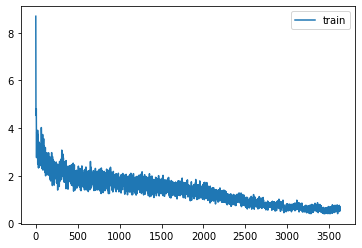

In [494]:
plt.plot(train_loss_lst)
plt.legend(['train'])

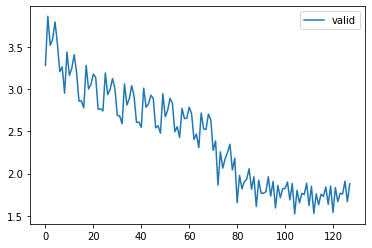

In [495]:
plt.plot(validation_loss_lst)
plt.legend(['valid'])

In [502]:
torch.save(model.state_dict(),'Attention_contextToHidden_bidirectional.pth') 

### Testing model over some random sentences 

In [500]:
#sentence = 'ich habe kein interesse am spielen .' # 'i dont have intrest in playing'
#sentence = 'ich bin heute glücklich .'  # 'i am happy today'
#sentence = 'eine frau mochte dieses gebäude .' # 'a woman liked that building'
#sentence = 'eines tages werde ich reich sein .'  # 'one day i will be rich'
sentence = 'ein mann lehnt sich in der nähe einer belebten straße an ein gebäude .'  # 'a man leans against a building near a busy street .'
#sentence = 'wer bin ich .'   # 'who am i'
#sentence = 'ein läufer <unk> sich für ein rennen aus dem <unk> .'  #runner leaving the starting blocks of a race .
sentence = sentence.split()
inputs = torch.zeros([len(sentence)+2],dtype=torch.long)
inputs[0] = 2
inputs[-1]  = 3
#a[1] = 1180
for i in range(0,len(sentence)):
    inputs[i+1] = german.vocab.stoi[sentence[i]]
    
print(inputs)
print(sentence)

tensor([  2,   5,  13, 287,  23,   7,  15, 110,  14, 340,  34,  21,   5, 104,
          4,   3])
['ein', 'mann', 'lehnt', 'sich', 'in', 'der', 'nähe', 'einer', 'belebten', 'straße', 'an', 'ein', 'gebäude', '.']


In [501]:
translation = ''

word = '<sos>'
word_index = 2
enc_seq_len = inputs.shape[0]
dec_seq_len = 1
batch_size = 1
hidden = encoder.initHidden(1)
cell = encoder.initHidden(1)
enc_hidden,(hidden,cell) = encoder(inputs.view(-1,1).to(device),hidden.to(device),cell.to(device))
hidden = torch.cat((hidden[:encoder.num_layers],hidden[encoder.num_layers:]),dim=-1)
cell = torch.cat((cell[:encoder.num_layers],cell[encoder.num_layers:]),dim=-1)
c = torch.zeros([1,2*hidden_size]).to(device)

while(word!='<eos>'):
    dec_hidden,(hidden,cell) = decoder(torch.tensor([word_index]).to(device),c,hidden,cell)
    h = dec_hidden[0]              # batch, hidden
    a = torch.sum(torch.mul(enc_hidden,h),axis=-1)
    a = model.softmax(a)
    c = torch.sum(torch.mul(enc_hidden,a.view(enc_seq_len,batch_size,1)),axis=0)
    c = model.tanh(c)
    c = torch.cat((c,h),dim=-1)
    c = model.tanh(c)
    o = model.fc(c)
    word_index = torch.argmax(o).item()
    
    word = english.vocab.itos[word_index]
    if(word!='<eos>'):
        translation = translation + " " + word
print(translation)

 a man is standing by a building near a busy city street .


### Bleu score 

encodings function takes sentences and returns their encodings. This will be used to calculate Bleu score

In [276]:
def encodings(src,trg):
    src_enc = torch.zeros([len(src)+2],dtype=torch.long)
    trg_enc = torch.zeros([len(trg)+2],dtype=torch.long)
    src_enc[0] = 2
    src_enc[-1] = 3
    trg_enc[0] = 2
    trg_enc[-1] = 3
    for i in range(len(src)):
        src_enc[i+1] = german.vocab.stoi[src[i]]
    for i in range(len(trg)):
        trg_enc[i+1] = english.vocab.stoi[trg[i]]
    return(src_enc,trg_enc)

In [509]:
from torchtext.data.metrics import bleu_score


The following cell iterates through test set and passes source sentences to find their translations. Both actual and predicted translations are stored in corresponding lists. They are used further to calculate bleu score

In [503]:
predicted_target = []
target = []
for n,i in enumerate(test_data):
    src = vars(train_data[n])['src']
    trg = vars(train_data[n])['trg']

    src_enc,trg_enc = encodings(src,trg)

    inputs = torch.tensor(src_enc)

    translation = []
    count = 0

    word = '<sos>'
    word_index = 2
    enc_seq_len = inputs.shape[0]
    dec_seq_len = 1
    batch_size = 1
    hidden = encoder.initHidden(1)
    cell = encoder.initHidden(1)
    enc_hidden,(hidden,cell) = encoder(inputs.view(-1,1).to(device),hidden.to(device),cell.to(device))
    hidden = torch.cat((hidden[:encoder.num_layers],hidden[encoder.num_layers:]),dim=-1)
    cell = torch.cat((cell[:encoder.num_layers],cell[encoder.num_layers:]),dim=-1)
    c = torch.zeros([1,2*hidden_size]).to(device)
    
    while(word!='<eos>' and count<50):
        dec_hidden,(hidden,cell) = decoder(torch.tensor([word_index]).to(device),c,hidden,cell)
        h = dec_hidden[0]              # batch, hidden
        a = torch.sum(torch.mul(enc_hidden,h),axis=-1)
        a = model.softmax(a)
        c = torch.sum(torch.mul(enc_hidden,a.view(enc_seq_len,batch_size,1)),axis=0)
        c = model.tanh(c)
        c = torch.cat((c,h),dim=-1)
        c = model.tanh(c)
        o = model.fc(c)
        word_index = torch.argmax(o).item()
        
        word = english.vocab.itos[word_index]
        if(word!='<eos>'):
            translation.append(word)
            count+=1
    target.append(trg)
    predicted_target.append(translation)
    

        
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


In [510]:
bscore = bleu_score(predicted_target, target)

In [ ]:
bscore

Bleu score of 30.2 was obtained.
Below are some test sentences and their predicted translation

In [507]:
for i in range(10):
  print(predicted_target[i])
  print(target[i])
  print()

['two', 'white', 'men', 'are', 'outside', 'near', 'some', 'sort', 'of', 'canopy', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']

['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', '<unk>', 'sign', '.']
['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']

['a', 'little', 'girl', 'is', 'climbing', 'a', 'snow', 'covered', 'fence', '.']
['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']

['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.']
['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'ladder', 'cleaning', 'a', 'window', '.']

['speaks', 'at', 'the', 'stove', 'preparing', 'food', '.']
['two', 'men', 'are', 'at', 'the', 'stove', 'preparing', 'food', '.']

['a', 'green', ',', 'green', ',', 'green', ',', 'and', 'the', 'other', 'man', 'looking', 'back', 'as', 'the', 'other', 'm